In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np
import scipy
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [2]:
#LOAD THE NEW TRAIN AND TEST

DATA_DIR = "/kaggle/input/amia-public-challenge-2024/"
TRAIN_DIR = os.path.join(DATA_DIR, "train/train")
TEST_DIR = os.path.join(DATA_DIR, "test/test")

# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print(f"\n... The number of training files is {len(TRAIN_DICOM_PATHS)} ...")
print(f"... The number of testing files is {len(TEST_DICOM_PATHS)} ...")

# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
# SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)
# ss_df_org = pd.read_csv(SS_CSV)

print("\n\nTRAIN DATAFRAME\n\n")
display(train_df.head(3))


TEST_CSV = os.path.join(DATA_DIR, "test.csv")
# SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")
# Create the relevant dataframe objects
test_df = pd.read_csv(TEST_CSV)


IMG_SIZE_CSV = os.path.join(DATA_DIR, "img_size.csv")
img_size_df = pd.read_csv(IMG_SIZE_CSV)



... The number of training files is 8573 ...
... The number of testing files is 6427 ...


TRAIN DATAFRAME




,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,No finding,14,R5,NaN,NaN,NaN,NaN
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R10,1148.0,503.0,1466.0,823.0
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,Consolidation,4,R8,264.0,732.0,550.0,1119.0


Custom dataset in pytorch

In [3]:
batch_size = 512 # HERE ADJUST IF NEEDED

In [4]:
 # HERE ADJUST IF NEEDED

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=3)
])

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, train=True):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0] + '.png'  # Assuming images are stored as png files
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        #convert to color
        # Convert to RGB if the image is grayscale
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.train:
            if (self.dataframe.iloc[idx, 2]==14):
                 class_id = 0 # normal
            else:
                 class_id = 1 # lesion
#            class_id = self.dataframe.iloc[idx, 2]  # Class ID
        else:
            class_id = 0 # we don't know the label for the test.
        if self.transform:
                image = self.transform(image)

        return image, class_id

In [5]:
# Create custom datasets and dataloaders
train_dataset = CustomDataset(dataframe=train_df, root_dir=TRAIN_DIR, train=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(dataframe=test_df, root_dir=TEST_DIR,train=False,transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [6]:
# Define model architecture
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification
#model.fc = nn.Linear(num_ftrs, 15)  # Binary classification

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
model.eval()  # Set the model to evaluation mode

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

if NUM_GPU > 1:
    model = nn.DataParallel(model)

[INFO] number of GPUs found: 2...


In [1]:
'''# Define the model architecture
model = models.resnet50(pretrained=False)  # Load ResNet-50 without pretrained weights
model.fc = nn.Linear(model.fc.in_features, 1)  # Modify the final layer for binary classification

# Load the model weights
model.load_state_dict(torch.load('/kaggle/input/amia-resnet50-bsize64-5epochs/pytorch/v1/1/ResNet50_binary_BSIZE64_5EPOCH.pth'))

# Move the model to the appropriate device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'''

"# Define the model architecture\nmodel = models.resnet50(pretrained=False)  # Load ResNet-50 without pretrained weights\nmodel.fc = nn.Linear(model.fc.in_features, 1)  # Modify the final layer for binary classification\n\n# Load the model weights\nmodel.load_state_dict(torch.load('/kaggle/input/amia-resnet50-bsize64-5epochs/pytorch/v1/1/ResNet50_binary_BSIZE64_5EPOCH.pth'))\n\n# Move the model to the appropriate device (GPU if available)\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n"

In [8]:
'''# Define model architecture
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification
#model.fc = nn.Linear(num_ftrs, 15)  # Binary classification

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)'''

'# Define model architecture\nmodel = models.resnet50(pretrained=True)\nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, 2)  # Binary classification\n#model.fc = nn.Linear(num_ftrs, 15)  # Binary classification\n\n# Define loss function and optimizer\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n# Train the model\nnum_epochs = 5\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nprint(device)'

In [8]:
model.to(device)
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader, 0):  # Unpack data from dataloader
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.551
[1,    20] loss: 0.177
[1,    30] loss: 0.141
[1,    40] loss: 0.118
[1,    50] loss: 0.100
[1,    60] loss: 0.092
[1,    70] loss: 0.076
[1,    80] loss: 0.062
[1,    90] loss: 0.059
[2,    10] loss: 0.039
[2,    20] loss: 0.024
[2,    30] loss: 0.023
[2,    40] loss: 0.025
[2,    50] loss: 0.032
[2,    60] loss: 0.029
[2,    70] loss: 0.030
[2,    80] loss: 0.022
[2,    90] loss: 0.013
[3,    10] loss: 0.012
[3,    20] loss: 0.011
[3,    30] loss: 0.012
[3,    40] loss: 0.011
[3,    50] loss: 0.010
[3,    60] loss: 0.010
[3,    70] loss: 0.005
[3,    80] loss: 0.005
[3,    90] loss: 0.006
[4,    10] loss: 0.006
[4,    20] loss: 0.012
[4,    30] loss: 0.012
[4,    40] loss: 0.015
[4,    50] loss: 0.014
[4,    60] loss: 0.011
[4,    70] loss: 0.011
[4,    80] loss: 0.006
[4,    90] loss: 0.005
[5,    10] loss: 0.005
[5,    20] loss: 0.008
[5,    30] loss: 0.007
[5,    40] loss: 0.004
[5,    50] loss: 0.006
[5,    60] loss: 0.011
[5,    70] loss: 0.007
[5,    80] 

In [10]:
torch.save(model.state_dict(), 'amia-resnet18_512batch_5epoch_inference_BINARY_CLASSIFICATION.pth')

In [11]:
torch.save(model,'amia-resnet18-512b-model_BINARY_CLASSIFICATION.pth')
    

In [12]:
import torch.nn.functional as F
# Inference on the test dataset
model.eval()
test_predictions = []
test_probabilities = []
with torch.no_grad():
    for i, data in enumerate (test_dataloader):
        print("doing batch",i)
        # Unpack the data batch
        inputs, _ = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs = inputs.to(device)

        # Move model to the same device as inputs
        model = model.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities,_ = torch.max(F.softmax(outputs, dim=1),1)

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
#         print (test_probabilities)

# Assuming you want to add predictions to the test dataframe
test_df['predicted_class'] = test_predictions
test_df['probabilities'] = test_probabilities
print(test_df.head())


doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42
                           image_id  predicted_class  probabilities
0  3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c                1       0.988554
1  LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm                0       1.000000
2  PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W                0       1.000000
3  l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL                0       0.985912
4  if5Pqu95xLUtURzAo72YiSg8GNzJb1F3                0       0.999999


In [21]:
# Inference on the test dataset
test_predictions = []
test_probabilities = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        print("doing batch", i)
        # Unpack the data batch
        inputs, labels = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities = F.softmax(outputs, dim=1).max(dim=1)[0]

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 22
doing batch 23
doing batch 24
doing batch 25
doing batch 26
doing batch 27
doing batch 28
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42


In [22]:
from sklearn.metrics import precision_recall_fscore_support


test_df['predicted_class'] = test_predictions
test_df['probabilities'] = test_probabilities
print(test_df.head())

# Calculate the F1, Precision, and Recall scores for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, test_predictions, average=None)

for i in range(len(precision)):
    print(f'Class {i}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1 Score: {f1[i]}')

                           image_id  predicted_class  probabilities
0  3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c                1       0.988554
1  LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm                0       1.000000
2  PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W                0       1.000000
3  l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL                0       0.985912
4  if5Pqu95xLUtURzAo72YiSg8GNzJb1F3                0       0.999999
Class 0:
Precision: 1.0
Recall: 0.7363227068079494
F1 Score: 0.8481403876375065
Class 1:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


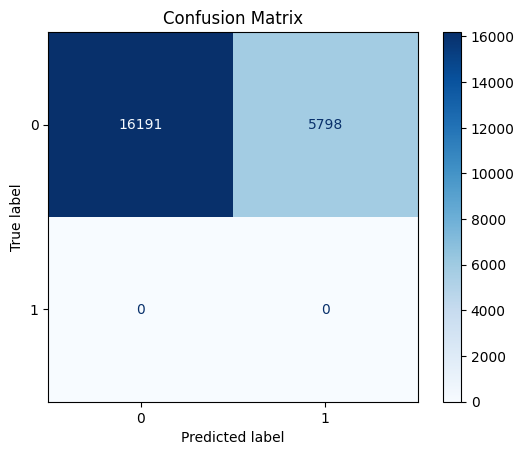

In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming test_predictions, test_probabilities, and all_labels are already populated as per your code

# Compute the confusion matrix
cm = confusion_matrix(all_labels, test_predictions)

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [24]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [25]:
model.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [29]:
model.eval()  # Establecer el modelo en modo evaluación

# Mover el modelo a la GPU si está disponible y envolverlo en DataParallel si hay múltiples GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [30]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        if target_class is None:
            target_class = input_image.argmax(dim=1).item()

        self.model.zero_grad()
        output = self.model(input_image)

        if isinstance(output, list):
            output = output[0]

        loss = output[0, target_class]
        loss.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam


In [31]:
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

image_path = '/kaggle/input/amia-public-challenge-2024/test/test/04ZlzYumAc41Dqte6vo17HWA19Ra6Amp.png'
input_image = preprocess_image(image_path).to(device)


In [33]:
# Acceder al módulo subyacente si el modelo está envuelto en DataParallel
if isinstance(model, torch.nn.DataParallel):
    model = model.module

# Usar la capa adecuada para ResNet-18
target_layer = model.layer4[1].conv2
grad_cam = GradCAM(model, target_layer)

# Generar Grad-CAM
cam = grad_cam.generate_cam(input_image)

# Visualizar el Grad-CAM
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(img)
    cam_image = cam_image / np.max(cam_image)
    return np.uint8(255 * cam_image)

# Convertir imagen a formato numpy
image = Image.open(image_path).convert('RGB')
image = np.array(image.resize((224, 224))) / 255

# Mostrar la imagen con Grad-CAM
cam_image = show_cam_on_image(image, cam)
plt.imshow(cam_image)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()



AttributeError: 'DataParallel' object has no attribute 'layer4'

In [26]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        if target_class is None:
            target_class = input_image.argmax(dim=1).item()

        self.model.zero_grad()
        output = self.model(input_image)

        if isinstance(output, list):
            output = output[0]

        loss = output[0, target_class]
        loss.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam


In [27]:
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

image_path = '/kaggle/input/amia-public-challenge-2024/test/test/05T7iqWLIK8eWE8jN5iOdaVxy4RAbaRJ.png'
input_image = preprocess_image(image_path).to(device)


In [28]:
# Usar la capa adecuada para ResNet-18
target_layer = model.layer4[1].conv2
grad_cam = GradCAM(model, target_layer)

# Generar Grad-CAM
cam = grad_cam.generate_cam(input_image)

# Visualizar el Grad-CAM
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(img)
    cam_image = cam_image / np.max(cam_image)
    return np.uint8(255 * cam_image)

# Convertir imagen a formato numpy
image = Image.open(image_path).convert('RGB')
image = np.array(image.resize((224, 224))) / 255

# Mostrar la imagen con Grad-CAM
cam_image = show_cam_on_image(image, cam)
plt.imshow(cam_image)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()


AttributeError: 'DataParallel' object has no attribute 'layer4'

In [ ]:
# UNITL HERE ! 

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs).squeeze(1)
            preds = (outputs > 0.5).float()

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {int(preds[j].item())}, true: {int(labels[j].item())}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs).squeeze(1)
            preds = (outputs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Convert lists to numpy arrays and ensure they are 1-dimensional
    all_labels = np.array(all_labels).astype(int)
    all_preds = np.array(all_preds).astype(int)

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=['No Trombo', 'Trombo'])

    print(f'Accuracy: {acc:.4f}')
    print('Confusion Matrix:')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Trombo', 'Trombo'], yticklabels=['No Trombo', 'Trombo'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    print('Classification Report:')
    print(cr)


In [18]:
evaluate_model(model, test_dataloader)

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [6]:
import timm
model = timm.create_model('resnet50', pretrained=True)

# Modificar la última capa para clasificación binaria
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
#model.eval()

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [7]:
# HERE PUT THE MODEL WE WANT TO PREDICT

model.load_state_dict(torch.load("/kaggle/input/amia-resnet50-bsize64-5epochs/pytorch/v1/1/ResNet50_binary_BSIZE64_5EPOCH.pth"))

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "module.conv1.weight", "module.bn1.weight", "module.bn1.bias", "module.bn1.running_mean", "module.bn1.running_var", "module.bn1.num_batches_tracked", "module.layer1.0.conv1.weight", "module.layer1.0.bn1.weight", "module.layer1.0.bn1.bias", "module.layer1.0.bn1.running_mean", "module.layer1.0.bn1.running_var", "module.layer1.0.bn1.num_batches_tracked", "module.layer1.0.conv2.weight", "module.layer1.0.bn2.weight", "module.layer1.0.bn2.bias", "module.layer1.0.bn2.running_mean", "module.layer1.0.bn2.running_var", "module.layer1.0.bn2.num_batches_tracked", "module.layer1.0.conv3.weight", "module.layer1.0.bn3.weight", "module.layer1.0.bn3.bias", "module.layer1.0.bn3.running_mean", "module.layer1.0.bn3.running_var", "module.layer1.0.bn3.num_batches_tracked", "module.layer1.0.downsample.0.weight", "module.layer1.0.downsample.1.weight", "module.layer1.0.downsample.1.bias", "module.layer1.0.downsample.1.running_mean", "module.layer1.0.downsample.1.running_var", "module.layer1.0.downsample.1.num_batches_tracked", "module.layer1.1.conv1.weight", "module.layer1.1.bn1.weight", "module.layer1.1.bn1.bias", "module.layer1.1.bn1.running_mean", "module.layer1.1.bn1.running_var", "module.layer1.1.bn1.num_batches_tracked", "module.layer1.1.conv2.weight", "module.layer1.1.bn2.weight", "module.layer1.1.bn2.bias", "module.layer1.1.bn2.running_mean", "module.layer1.1.bn2.running_var", "module.layer1.1.bn2.num_batches_tracked", "module.layer1.1.conv3.weight", "module.layer1.1.bn3.weight", "module.layer1.1.bn3.bias", "module.layer1.1.bn3.running_mean", "module.layer1.1.bn3.running_var", "module.layer1.1.bn3.num_batches_tracked", "module.layer1.2.conv1.weight", "module.layer1.2.bn1.weight", "module.layer1.2.bn1.bias", "module.layer1.2.bn1.running_mean", "module.layer1.2.bn1.running_var", "module.layer1.2.bn1.num_batches_tracked", "module.layer1.2.conv2.weight", "module.layer1.2.bn2.weight", "module.layer1.2.bn2.bias", "module.layer1.2.bn2.running_mean", "module.layer1.2.bn2.running_var", "module.layer1.2.bn2.num_batches_tracked", "module.layer1.2.conv3.weight", "module.layer1.2.bn3.weight", "module.layer1.2.bn3.bias", "module.layer1.2.bn3.running_mean", "module.layer1.2.bn3.running_var", "module.layer1.2.bn3.num_batches_tracked", "module.layer2.0.conv1.weight", "module.layer2.0.bn1.weight", "module.layer2.0.bn1.bias", "module.layer2.0.bn1.running_mean", "module.layer2.0.bn1.running_var", "module.layer2.0.bn1.num_batches_tracked", "module.layer2.0.conv2.weight", "module.layer2.0.bn2.weight", "module.layer2.0.bn2.bias", "module.layer2.0.bn2.running_mean", "module.layer2.0.bn2.running_var", "module.layer2.0.bn2.num_batches_tracked", "module.layer2.0.conv3.weight", "module.layer2.0.bn3.weight", "module.layer2.0.bn3.bias", "module.layer2.0.bn3.running_mean", "module.layer2.0.bn3.running_var", "module.layer2.0.bn3.num_batches_tracked", "module.layer2.0.downsample.0.weight", "module.layer2.0.downsample.1.weight", "module.layer2.0.downsample.1.bias", "module.layer2.0.downsample.1.running_mean", "module.layer2.0.downsample.1.running_var", "module.layer2.0.downsample.1.num_batches_tracked", "module.layer2.1.conv1.weight", "module.layer2.1.bn1.weight", "module.layer2.1.bn1.bias", "module.layer2.1.bn1.running_mean", "module.layer2.1.bn1.running_var", "module.layer2.1.bn1.num_batches_tracked", "module.layer2.1.conv2.weight", "module.layer2.1.bn2.weight", "module.layer2.1.bn2.bias", "module.layer2.1.bn2.running_mean", "module.layer2.1.bn2.running_var", "module.layer2.1.bn2.num_batches_tracked", "module.layer2.1.conv3.weight", "module.layer2.1.bn3.weight", "module.layer2.1.bn3.bias", "module.layer2.1.bn3.running_mean", "module.layer2.1.bn3.running_var", "module.layer2.1.bn3.num_batches_tracked", "module.layer2.2.conv1.weight", "module.layer2.2.bn1.weight", "module.layer2.2.bn1.bias", "module.layer2.2.bn1.running_mean", "module.layer2.2.bn1.running_var", "module.layer2.2.bn1.num_batches_tracked", "module.layer2.2.conv2.weight", "module.layer2.2.bn2.weight", "module.layer2.2.bn2.bias", "module.layer2.2.bn2.running_mean", "module.layer2.2.bn2.running_var", "module.layer2.2.bn2.num_batches_tracked", "module.layer2.2.conv3.weight", "module.layer2.2.bn3.weight", "module.layer2.2.bn3.bias", "module.layer2.2.bn3.running_mean", "module.layer2.2.bn3.running_var", "module.layer2.2.bn3.num_batches_tracked", "module.layer2.3.conv1.weight", "module.layer2.3.bn1.weight", "module.layer2.3.bn1.bias", "module.layer2.3.bn1.running_mean", "module.layer2.3.bn1.running_var", "module.layer2.3.bn1.num_batches_tracked", "module.layer2.3.conv2.weight", "module.layer2.3.bn2.weight", "module.layer2.3.bn2.bias", "module.layer2.3.bn2.running_mean", "module.layer2.3.bn2.running_var", "module.layer2.3.bn2.num_batches_tracked", "module.layer2.3.conv3.weight", "module.layer2.3.bn3.weight", "module.layer2.3.bn3.bias", "module.layer2.3.bn3.running_mean", "module.layer2.3.bn3.running_var", "module.layer2.3.bn3.num_batches_tracked", "module.layer3.0.conv1.weight", "module.layer3.0.bn1.weight", "module.layer3.0.bn1.bias", "module.layer3.0.bn1.running_mean", "module.layer3.0.bn1.running_var", "module.layer3.0.bn1.num_batches_tracked", "module.layer3.0.conv2.weight", "module.layer3.0.bn2.weight", "module.layer3.0.bn2.bias", "module.layer3.0.bn2.running_mean", "module.layer3.0.bn2.running_var", "module.layer3.0.bn2.num_batches_tracked", "module.layer3.0.conv3.weight", "module.layer3.0.bn3.weight", "module.layer3.0.bn3.bias", "module.layer3.0.bn3.running_mean", "module.layer3.0.bn3.running_var", "module.layer3.0.bn3.num_batches_tracked", "module.layer3.0.downsample.0.weight", "module.layer3.0.downsample.1.weight", "module.layer3.0.downsample.1.bias", "module.layer3.0.downsample.1.running_mean", "module.layer3.0.downsample.1.running_var", "module.layer3.0.downsample.1.num_batches_tracked", "module.layer3.1.conv1.weight", "module.layer3.1.bn1.weight", "module.layer3.1.bn1.bias", "module.layer3.1.bn1.running_mean", "module.layer3.1.bn1.running_var", "module.layer3.1.bn1.num_batches_tracked", "module.layer3.1.conv2.weight", "module.layer3.1.bn2.weight", "module.layer3.1.bn2.bias", "module.layer3.1.bn2.running_mean", "module.layer3.1.bn2.running_var", "module.layer3.1.bn2.num_batches_tracked", "module.layer3.1.conv3.weight", "module.layer3.1.bn3.weight", "module.layer3.1.bn3.bias", "module.layer3.1.bn3.running_mean", "module.layer3.1.bn3.running_var", "module.layer3.1.bn3.num_batches_tracked", "module.layer3.2.conv1.weight", "module.layer3.2.bn1.weight", "module.layer3.2.bn1.bias", "module.layer3.2.bn1.running_mean", "module.layer3.2.bn1.running_var", "module.layer3.2.bn1.num_batches_tracked", "module.layer3.2.conv2.weight", "module.layer3.2.bn2.weight", "module.layer3.2.bn2.bias", "module.layer3.2.bn2.running_mean", "module.layer3.2.bn2.running_var", "module.layer3.2.bn2.num_batches_tracked", "module.layer3.2.conv3.weight", "module.layer3.2.bn3.weight", "module.layer3.2.bn3.bias", "module.layer3.2.bn3.running_mean", "module.layer3.2.bn3.running_var", "module.layer3.2.bn3.num_batches_tracked", "module.layer3.3.conv1.weight", "module.layer3.3.bn1.weight", "module.layer3.3.bn1.bias", "module.layer3.3.bn1.running_mean", "module.layer3.3.bn1.running_var", "module.layer3.3.bn1.num_batches_tracked", "module.layer3.3.conv2.weight", "module.layer3.3.bn2.weight", "module.layer3.3.bn2.bias", "module.layer3.3.bn2.running_mean", "module.layer3.3.bn2.running_var", "module.layer3.3.bn2.num_batches_tracked", "module.layer3.3.conv3.weight", "module.layer3.3.bn3.weight", "module.layer3.3.bn3.bias", "module.layer3.3.bn3.running_mean", "module.layer3.3.bn3.running_var", "module.layer3.3.bn3.num_batches_tracked", "module.layer3.4.conv1.weight", "module.layer3.4.bn1.weight", "module.layer3.4.bn1.bias", "module.layer3.4.bn1.running_mean", "module.layer3.4.bn1.running_var", "module.layer3.4.bn1.num_batches_tracked", "module.layer3.4.conv2.weight", "module.layer3.4.bn2.weight", "module.layer3.4.bn2.bias", "module.layer3.4.bn2.running_mean", "module.layer3.4.bn2.running_var", "module.layer3.4.bn2.num_batches_tracked", "module.layer3.4.conv3.weight", "module.layer3.4.bn3.weight", "module.layer3.4.bn3.bias", "module.layer3.4.bn3.running_mean", "module.layer3.4.bn3.running_var", "module.layer3.4.bn3.num_batches_tracked", "module.layer3.5.conv1.weight", "module.layer3.5.bn1.weight", "module.layer3.5.bn1.bias", "module.layer3.5.bn1.running_mean", "module.layer3.5.bn1.running_var", "module.layer3.5.bn1.num_batches_tracked", "module.layer3.5.conv2.weight", "module.layer3.5.bn2.weight", "module.layer3.5.bn2.bias", "module.layer3.5.bn2.running_mean", "module.layer3.5.bn2.running_var", "module.layer3.5.bn2.num_batches_tracked", "module.layer3.5.conv3.weight", "module.layer3.5.bn3.weight", "module.layer3.5.bn3.bias", "module.layer3.5.bn3.running_mean", "module.layer3.5.bn3.running_var", "module.layer3.5.bn3.num_batches_tracked", "module.layer4.0.conv1.weight", "module.layer4.0.bn1.weight", "module.layer4.0.bn1.bias", "module.layer4.0.bn1.running_mean", "module.layer4.0.bn1.running_var", "module.layer4.0.bn1.num_batches_tracked", "module.layer4.0.conv2.weight", "module.layer4.0.bn2.weight", "module.layer4.0.bn2.bias", "module.layer4.0.bn2.running_mean", "module.layer4.0.bn2.running_var", "module.layer4.0.bn2.num_batches_tracked", "module.layer4.0.conv3.weight", "module.layer4.0.bn3.weight", "module.layer4.0.bn3.bias", "module.layer4.0.bn3.running_mean", "module.layer4.0.bn3.running_var", "module.layer4.0.bn3.num_batches_tracked", "module.layer4.0.downsample.0.weight", "module.layer4.0.downsample.1.weight", "module.layer4.0.downsample.1.bias", "module.layer4.0.downsample.1.running_mean", "module.layer4.0.downsample.1.running_var", "module.layer4.0.downsample.1.num_batches_tracked", "module.layer4.1.conv1.weight", "module.layer4.1.bn1.weight", "module.layer4.1.bn1.bias", "module.layer4.1.bn1.running_mean", "module.layer4.1.bn1.running_var", "module.layer4.1.bn1.num_batches_tracked", "module.layer4.1.conv2.weight", "module.layer4.1.bn2.weight", "module.layer4.1.bn2.bias", "module.layer4.1.bn2.running_mean", "module.layer4.1.bn2.running_var", "module.layer4.1.bn2.num_batches_tracked", "module.layer4.1.conv3.weight", "module.layer4.1.bn3.weight", "module.layer4.1.bn3.bias", "module.layer4.1.bn3.running_mean", "module.layer4.1.bn3.running_var", "module.layer4.1.bn3.num_batches_tracked", "module.layer4.2.conv1.weight", "module.layer4.2.bn1.weight", "module.layer4.2.bn1.bias", "module.layer4.2.bn1.running_mean", "module.layer4.2.bn1.running_var", "module.layer4.2.bn1.num_batches_tracked", "module.layer4.2.conv2.weight", "module.layer4.2.bn2.weight", "module.layer4.2.bn2.bias", "module.layer4.2.bn2.running_mean", "module.layer4.2.bn2.running_var", "module.layer4.2.bn2.num_batches_tracked", "module.layer4.2.conv3.weight", "module.layer4.2.bn3.weight", "module.layer4.2.bn3.bias", "module.layer4.2.bn3.running_mean", "module.layer4.2.bn3.running_var", "module.layer4.2.bn3.num_batches_tracked", "module.fc.weight", "module.fc.bias". 

In [10]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
import torch.nn.functional as F
# Inference on the test dataset
model.eval()
test_predictions = []
test_probabilities = []
with torch.no_grad():
    for i, data in enumerate (test_dataloader):
        print("doing batch",i)
        # Unpack the data batch
        inputs, _ = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs = inputs.to(device)

        # Move model to the same device as inputs
        model = model.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities,_ = torch.max(F.softmax(outputs, dim=1),1)

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
#         print (test_probabilities)

# Assuming you want to add predictions to the test dataframe
test_df['predicted_class'] = test_predictions
test_df['probabilities'] = test_probabilities
print(test_df.head())


doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 22
doing batch 23
doing batch 24
doing batch 25
doing batch 26
doing batch 27
doing batch 28
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42
doing batch 43
doing batch 44
doing batch 45
doing batch 46
doing batch 47
doing batch 48
doing batch 49
doing batch 50
doing batch 51
doing batch 52
doing batch 53
doing batch 54
doing batch 55
doing batch 56
doing batch 57
doing batch 58
doing batch 59
doing batch 60
doing batch 61
doing batch 62
doing batch 63
doing batch 64
doing batch 65
doing batch 66
doing

In [12]:
test_df['Prob']  = test_df['probabilities'].max()
    
test_df

,image_id,predicted_class,probabilities,Prob
0,3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c,13,0.339730,1.0
1,LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm,14,1.000000,1.0
2,PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W,14,1.000000,1.0
3,l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL,14,1.000000,1.0
4,if5Pqu95xLUtURzAo72YiSg8GNzJb1F3,14,1.000000,1.0
...,...,...,...,...
21984,k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM,14,1.000000,1.0
21985,yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn,14,0.999976,1.0
21986,yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa,14,1.000000,1.0
21987,1oO2FHrNonZqP9i854X6sio2hZj4R4h0,5,0.348019,1.0


In [13]:
test_df.to_csv('test_predictions.csv', index=False) #SAVE THIS RESULT! 

In [16]:
'''test_df = pd.read_csv('test_predictions.csv')
test_df.head()'''

# change 0 for 14
# change 1 for 0
test_df['predicted_class'] = test_df['predicted_class'].replace(0, 14)
test_df['predicted_class'] = test_df['predicted_class'].replace(1, 0)

def prepare_pred(row):
    prob = str(row['probabilities']) if not pd.isna(row['probabilities']) else '0'  # Convert NaN to '0'
    if row['predicted_class'] == 14: 
        return '14 ' + prob + ' 0 0 1 1'
    else:
        return str(row['predicted_class']) + ' ' + prob + ' 700 700 1000 1000'
    
# Apply the function to add text to specific rows
test_df['PredictionString'] = test_df.apply(prepare_pred, axis=1)

# # Create a new column by concatenating 'predicted_class' and 'Prob' as strings
# test_df['PredictionString'] = test_df['predicted_class'].astype(str) + ' ' + test_df['Prob'].astype(str) + ' 0 0 1 1'

# Create a new DataFrame with 'image_id' and 'new_column'
test_df_submit = test_df[['image_id', 'PredictionString']]

print(test_df_submit)

test_df_submit = test_df_submit.drop_duplicates()
# duplicate_rows = test_df_submit[test_df_submit.duplicated()]

# if duplicate_rows.empty:
#     print("No duplicate rows found.")
# else:
#     print("Duplicate rows found:")
#     print(duplicate_rows)


#### Part of Submit in the Challenge form ####


# Concatenar los resultados de filas con IDs repetidos
df_concatenado = test_df_submit.groupby('image_id')['PredictionString'].apply(' '.join).reset_index()

# Guardar el dataframe en un archivo CSV
df_concatenado.to_csv('submission.csv', index=False)


df_concatenado


                               image_id  \
0      3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c   
1      LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm   
2      PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W   
3      l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL   
4      if5Pqu95xLUtURzAo72YiSg8GNzJb1F3   
...                                 ...   
21984  k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM   
21985  yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn   
21986  yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa   
21987  1oO2FHrNonZqP9i854X6sio2hZj4R4h0   
21988  8Q8fPobVc11InzzHAKDfjH2emkfnEdnC   

                              PredictionString  
0      13 0.3397303819656372 700 700 1000 1000  
1                               14 1.0 0 0 1 1  
2                               14 1.0 0 0 1 1  
3                               14 1.0 0 0 1 1  
4                               14 1.0 0 0 1 1  
...                                        ...  
21984                           14 1.0 0 0 1 1  
21985            14 0.9999759197235107 0 0 1 1  
21986                           14 1.0 0 0

,image_id,PredictionString
0,00X4Pb5TcOhWWwrDwn9UoRDJhwYRuusp,14 1.0 0 0 1 1
1,00eCz0yTwisqK7dgZKrdhLh4cMP9FewR,14 1.0 0 0 1 1
2,00wsXaGGLhOo977BBHmhbKVNu02fWdPl,14 1.0 0 0 1 1
3,02IEFam0BlSztSMY3YeA9svnDJOxTKDg,13 0.306283563375473 700 700 1000 1000
4,02fQeJYiEhOeebwkwE8wsD0FPyz8EWHD,14 1.0 0 0 1 1
...,...,...
6422,zxCwOtAINzbYU681ZHjc8GZvtOz9ErEr,14 1.0 0 0 1 1
6423,zxq5d7Jh3j2DTwdFqXMmH1OLUFRweQBE,14 0.44158539175987244 0 0 1 1
6424,zxxt4VNvrRQHUL58LBI4zDb11JZZ5NKz,14 1.0 0 0 1 1
6425,zyD6VqKYEQArknozKmmitQJEjhWqGxZI,14 1.0 0 0 1 1


In [20]:
# Inference on the test dataset
test_predictions = []
test_probabilities = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        print("doing batch", i)
        # Unpack the data batch
        inputs, labels = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities = F.softmax(outputs, dim=1).max(dim=1)[0]

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 22
doing batch 23
doing batch 24
doing batch 25
doing batch 26
doing batch 27
doing batch 28
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42
doing batch 43
doing batch 44
doing batch 45
doing batch 46
doing batch 47
doing batch 48
doing batch 49
doing batch 50
doing batch 51
doing batch 52
doing batch 53
doing batch 54
doing batch 55
doing batch 56
doing batch 57
doing batch 58
doing batch 59
doing batch 60
doing batch 61
doing batch 62
doing batch 63
doing batch 64
doing batch 65
doing batch 66
doing

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [23]:
from sklearn.metrics import precision_recall_fscore_support


In [24]:
# Assuming you want to add predictions to the test dataframe
test_df = pd.read_csv('/kaggle/input/amia-public-challenge-2024/test.csv')
test_df['predicted_class'] = test_predictions
test_df['probabilities'] = test_probabilities
print(test_df.head())

# Calculate the F1, Precision, and Recall scores for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, test_predictions, average=None)

for i in range(len(precision)):
    print(f'Class {i}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1 Score: {f1[i]}')

                           image_id  predicted_class  probabilities
0  3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c               13        0.33973
1  LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm               14        1.00000
2  PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W               14        1.00000
3  l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL               14        1.00000
4  if5Pqu95xLUtURzAo72YiSg8GNzJb1F3               14        1.00000
Class 0:
Precision: 1.0
Recall: 0.13906953476738368
F1 Score: 0.24418093983311373
Class 1:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 2:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 3:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 4:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 5:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 6:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 7:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 8:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 9:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 10:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Class 11:

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
